In [4]:
import Post_Donors_PreProcess

In [5]:
import GPy
import GPyOpt
import numpy as np

In [6]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score

In [7]:
#Post_Donor_PrePro : Preprocessing function that pulls from the original data
#Diet : Pull from a previously saved preprocessed csv, as to only do scaling and text processing

In [8]:
#X, y, df_cols, le_dict = Post_Donors_PreProcess.Post_Donor_PrePro(
#                            Tf_Features=100, Sample=1, 
#                            One_Hot=False, Standard_Scale=True)

In [ ]:
X, y, df_cols, le_dict = Post_Donors_PreProcess.Diet_Prepro(
                            Tf_Features=1000, 
                            One_Hot=False, 
                            Standard_Scale=True,
                            Force=True)

Encoding
Scaling
Text Processing


In [ ]:
lgbm_train_data = lgbm.Dataset(data=X#.drop('School Percentage Free Lunch',axis=1)
                               ,label=y)

In [ ]:
y.value_counts(normalize=True)

## Default

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [13]:
model = lgbm.LGBMClassifier()
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [14]:
roc_auc_score(y_test,model.predict(X_test))

 C:\Users\Namae\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.6792484045677456

## Random Search

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [16]:
model = lgbm.LGBMClassifier(
    boosting_type = 'dart',
    application= 'binary',
    learning_rate= 0.01,
    scale_pos_weight= 2,
    drop_rate= 0.2,)

In [17]:
params_rand2 = {'n_estimators': [x for x in range(50,200,20)],
             'feature_fraction': [x / 1000.0 for x in range(500,900,20)],
             'bagging_fraction': [x / 1000.0 for x in range(500,900,20)],
             'lambda_l2' : [x / 100.0 for x in range(0,310,10)],
             'boosting_type': ['dart','gbdt']}

In [18]:
rs = RandomizedSearchCV(
    model, 
    params_rand2, 
    n_iter=5,
    scoring='roc_auc',
    cv=5)

rs.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(application='binary', boosting_type='dart', class_weight=None,
        colsample_bytree=1.0, drop_rate=0.2, learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=2, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190], 'feature_fraction': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88], 'bagging_fraction': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0....1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0], 'boosting_type': ['dart', 'gbdt'

In [19]:
rs.best_score_

0.7332144218784066

In [20]:
rs.best_params_

{'n_estimators': 170,
 'lambda_l2': 2.6,
 'feature_fraction': 0.7,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.78}

In [21]:
del model, rs, X_train, X_test, y_train, y_test

## Bay Search

In [22]:
params_bay = [{'name': 'feature_fraction','type': 'continuous', 'domain': (500,900)},
              {'name': 'bagging_fraction','type': 'continuous', 'domain': (500,900)},
              {'name': 'lambda_l2',       'type': 'continuous', 'domain': (100,500)},
              {'name': 'n_estimators',      'type': 'continuous', 'domain': (100,600)}
             ]

In [23]:
def Bay_Wrapper(x):
    """
    Model Wrapper for Bay Opt 
    Wrapper used for LGBM & Bay:
    x[0][:] = list of all params for this aq
    """
    AUC = True
    if AUC: metric = 'auc'
    else: metric = 'binary_logloss'
    
    lgbm_params = { 'feature_fraction': x[0][0]/1000,
                    'bagging_fraction': x[0][1]/1000,
                    'lambda_l2' : x[0][2]/1000,
                    'boosting': 'gbdt',
                    'n_estimators' : int(x[0][3]),
                   
                    'application': 'binary',
                    'learning_rate': 0.01,
                    'scale_pos_weight': 2,
                    'drop_rate': 0.2,
}

    cv_results = lgbm.cv(train_set=lgbm_train_data,
                         params=lgbm_params, 
                         nfold=5,
                         num_boost_round = 600,
                         early_stopping_rounds=50,
                         metrics=[metric])

    optimum_boost_rounds = np.argmax(cv_results[metric+'-mean'])
    print('{} : {}'.format(metric,np.max(cv_results['{}-mean'.format(metric)])))
    
    return np.max(cv_results[metric+'-mean'])

In [24]:
bay = GPyOpt.methods.BayesianOptimization(Bay_Wrapper,
                                          params_bay,
                                          acquisition_type ='EI',   # LCB acquisition
                                          acquisition_weight = .5,  # Exploration exploitation
                                          maximize=True
                                         )

auc : 0.7386629328721757
auc : 0.7509672860270522
auc : 0.7391356973675924
auc : 0.7392145816854908
auc : 0.7513025576482032


In [25]:
bay.run_optimization(5) #GPyOpt uses 5 points + the number listed
print('Function after 5 Aquisitions')
bay.plot_acquisition()

auc : 0.7328887927241016
auc : 0.7592976260275621
auc : 0.7621758950596956
auc : 0.762023665970664
auc : 0.7331982634543424
Function after 5 Aquisitions


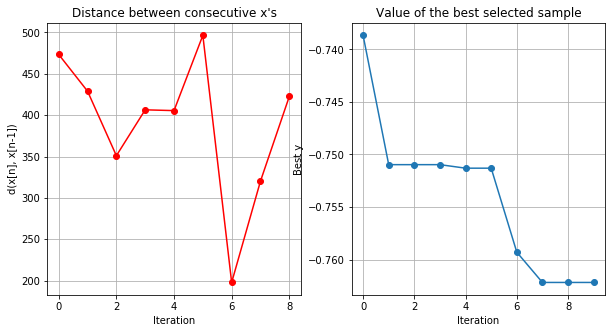

In [26]:
bay.plot_convergence()

In [27]:
bay.plot_acquisition()

In [ ]:
bay.run_optimization(20)
bay.plot_convergence()
bay.plot_acquisition()

In [29]:
bay_pred = bay.x_opt
print('feature_fraction: '+str(round(bay_pred[0]/1000,5)))
print('bagging_fraction: '+str(round(bay_pred[1]/1000,5)))
print('lambda_l2: '+str(round(bay_pred[2]/1000,5)))
print('n_estimators: '+str(round(bay_pred[3],5)))

feature_fraction: 0.77504
bagging_fraction: 0.56968
lambda_l2: 0.33976
n_estimators: 508.90725


In [36]:
final_params = {'feature_fraction': bay_pred[0]/1000,
                'bagging_fraction': bay_pred[1]/1000,
                'lambda_l2' : bay_pred[2]/1000,
                'boosting': 'gbdt',
                'n_estimators' : int(bay_pred[3]),
                   
                'application': 'binary',
                'learning_rate': 0.01,
                'scale_pos_weight': 2,
                'drop_rate': 0.2,
                'metric':'auc'}

 ## Final

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [39]:
model = lgbm.train(params=final_params,
                train_set=lgbm.Dataset(X_train,y_train),
                valid_sets=lgbm.Dataset(X_test,y_test),
                num_boost_round=600,
                early_stopping_rounds=50,
                verbose_eval=False)

In [40]:
roc_auc_score(y_test,model.predict(X_test))

0.7635483272082222

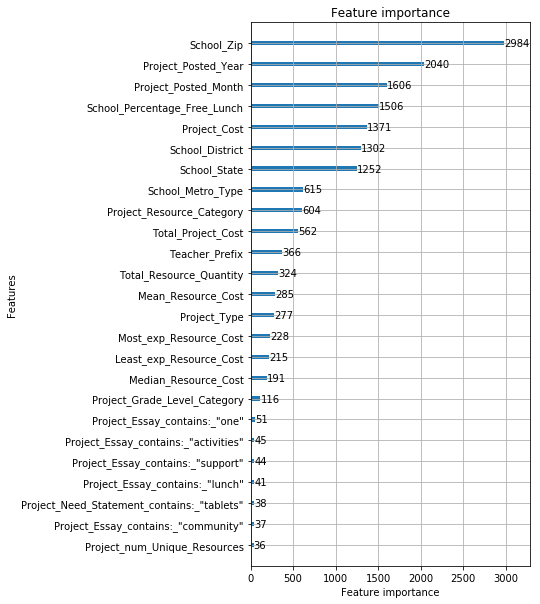

In [54]:
lgbm.plot_importance(model,max_num_features=25,figsize=(5,10));